## Introduction

In this notebook we are primarily concerned with the question: What attributes are involved with schools that have CS programs vs schools that do not? This question will be tackled first.

## TODO:
* Remove latitude/longitude
* Add Intro/Conclusion/other notes
* Experiment with binning
* * Try different strategies
* * Remove scaling of bins
* * Experiment with un-binned features, scaling instead
* Create new features with PCA results
* K-Fold Cross Validation

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
ospi_data = pd.read_csv('2022_school_pt5.csv',  index_col=0)

In [3]:
ospi_data.head()

,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,County,AllStudents,C_AllStudents,G_Female,GC_Female,...,D_NoDisability,DC_NoDisability,A_9,AC_9,A_10,AC_10,A_11,AC_11,A_12,AC_12
0,1109,3075,Washtucna Elementary/High School,-118.311231,46.752189,Adams,28,3,9,0,...,26,3,7,0,4,0,6,1,11,2
1,1147,3015,Othello High School,-119.165246,46.822710,Adams,1281,169,635,60,...,1086,140,382,51,328,44,321,29,250,45
2,1158,2903,Lind-Ritzville High School,-118.292516,47.125588,Adams,60,17,30,8,...,57,16,18,9,15,2,14,1,13,5
3,1160,2132,Ritzville High School,-118.292516,47.125588,Adams,113,18,57,9,...,107,14,32,5,35,3,25,3,21,7
4,2250,1617,Educational Opportunity Center,-117.057521,46.411019,Asotin,167,0,89,0,...,142,0,16,0,51,0,41,0,59,0


In [4]:
len(ospi_data.index)

730

In [5]:
ospi_data['AllStudents'].sum()

390223

In [6]:
ospi_data = ospi_data.iloc[:,:-15]

In [7]:
ospi_data.head()

,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,County,AllStudents,C_AllStudents,G_Female,GC_Female,...,RC_NA,R_TwoOrMore,RC_TwoOrMore,R_White,RC_White,L_ELL,LC_ELL,L_NoELL,LC_NoELL,I_LowIncome
0,1109,3075,Washtucna Elementary/High School,-118.311231,46.752189,Adams,28,3,9,0,...,0,2,0,24,3,0,0,28,3,17
1,1147,3015,Othello High School,-119.165246,46.822710,Adams,1281,169,635,60,...,0,3,0,98,17,402,54,879,115,1069
2,1158,2903,Lind-Ritzville High School,-118.292516,47.125588,Adams,60,17,30,8,...,0,4,2,32,5,7,3,53,14,48
3,1160,2132,Ritzville High School,-118.292516,47.125588,Adams,113,18,57,9,...,0,3,0,97,16,0,0,113,18,47
4,2250,1617,Educational Opportunity Center,-117.057521,46.411019,Asotin,167,0,89,0,...,0,5,0,148,0,0,0,167,0,133


In [8]:
def low_inc_perc(row):
    return row['I_LowIncome'] / row['AllStudents']

ospi_data['PercentLowIncome'] = ospi_data.apply(low_inc_perc, axis=1)

In [9]:
ospi_data.head()

,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,County,AllStudents,C_AllStudents,G_Female,GC_Female,...,R_TwoOrMore,RC_TwoOrMore,R_White,RC_White,L_ELL,LC_ELL,L_NoELL,LC_NoELL,I_LowIncome,PercentLowIncome
0,1109,3075,Washtucna Elementary/High School,-118.311231,46.752189,Adams,28,3,9,0,...,2,0,24,3,0,0,28,3,17,0.607143
1,1147,3015,Othello High School,-119.165246,46.822710,Adams,1281,169,635,60,...,3,0,98,17,402,54,879,115,1069,0.834504
2,1158,2903,Lind-Ritzville High School,-118.292516,47.125588,Adams,60,17,30,8,...,4,2,32,5,7,3,53,14,48,0.800000
3,1160,2132,Ritzville High School,-118.292516,47.125588,Adams,113,18,57,9,...,3,0,97,16,0,0,113,18,47,0.415929
4,2250,1617,Educational Opportunity Center,-117.057521,46.411019,Asotin,167,0,89,0,...,5,0,148,0,0,0,167,0,133,0.796407


In [10]:
pd.set_option('display.max_columns', None)
ospi_data.head()

,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,County,AllStudents,C_AllStudents,G_Female,GC_Female,G_Male,GC_Male,G_GenderX,GC_GenderX,R_Native,RC_Native,R_Asian,RC_Asian,R_Black,RC_Black,R_Hisp_Lat,RC_Hisp_Lat,R_HPI,RC_HPI,R_NA,RC_NA,R_TwoOrMore,RC_TwoOrMore,R_White,RC_White,L_ELL,LC_ELL,L_NoELL,LC_NoELL,I_LowIncome,PercentLowIncome
0,1109,3075,Washtucna Elementary/High School,-118.311231,46.752189,Adams,28,3,9,0,19,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,24,3,0,0,28,3,17,0.607143
1,1147,3015,Othello High School,-119.165246,46.822710,Adams,1281,169,635,60,646,109,0,0,0,0,5,1,2,0,1173,151,0,0,0,0,3,0,98,17,402,54,879,115,1069,0.834504
2,1158,2903,Lind-Ritzville High School,-118.292516,47.125588,Adams,60,17,30,8,29,9,1,0,0,0,0,0,1,0,23,10,0,0,0,0,4,2,32,5,7,3,53,14,48,0.800000
3,1160,2132,Ritzville High School,-118.292516,47.125588,Adams,113,18,57,9,56,9,0,0,2,2,2,0,0,0,9,0,0,0,0,0,3,0,97,16,0,0,113,18,47,0.415929
4,2250,1617,Educational Opportunity Center,-117.057521,46.411019,Asotin,167,0,89,0,78,0,0,0,1,0,0,0,2,0,11,0,0,0,0,0,5,0,148,0,0,0,167,0,133,0.796407


For the following, note that BIPOC does not include Asian in this calculation. The following calculation includes all reported racial identities except for Asian and white.

In [11]:
def number_bipoc(row):
    return (row['R_Native'] + row['R_Black'] + row['R_Hisp_Lat'] + row['R_HPI'] + row['R_TwoOrMore'])

ospi_data['R_BIPOC'] = ospi_data.apply(number_bipoc, axis=1)

In [12]:
def bipoc_perc(row):
    return (row['R_BIPOC']) / row['AllStudents']

ospi_data['PercentBIPOC'] = ospi_data.apply(bipoc_perc, axis=1)

## Preprocessing: Percentage of District Low Income and BIPOC

In [13]:
ospi_data['DistrictNumSchools'] = ospi_data.groupby('DistrictCode')['SchoolCode'].transform('size')
ospi_data['DistrictSize'] = ospi_data.groupby('DistrictCode')['AllStudents'].transform('sum')
ospi_data['DistrictLowIncome'] = ospi_data.groupby('DistrictCode')['I_LowIncome'].transform('sum')
ospi_data['DistrictPctLowIncome'] = ospi_data['DistrictLowIncome']/ospi_data['DistrictSize']
ospi_data['DistrictBIPOC'] = ospi_data.groupby('DistrictCode')['R_BIPOC'].transform('sum')
ospi_data['DistrictPctBIPOC'] = ospi_data['DistrictBIPOC']/ospi_data['DistrictSize']

In [14]:
columns_to_analyze = ['DistrictCode','SchoolCode','SchoolName','Longitude'
                      ,'Latitude','County','AllStudents','C_AllStudents', 'I_LowIncome', 'PercentLowIncome'
                      , 'R_BIPOC' ,'PercentBIPOC','DistrictNumSchools','DistrictSize','DistrictLowIncome','DistrictPctLowIncome'
                      ,'DistrictBIPOC','DistrictPctBIPOC']

reduced_ospi = ospi_data[columns_to_analyze]

In [15]:
reduced_ospi.head(25)

,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,County,AllStudents,C_AllStudents,I_LowIncome,PercentLowIncome,R_BIPOC,PercentBIPOC,DistrictNumSchools,DistrictSize,DistrictLowIncome,DistrictPctLowIncome,DistrictBIPOC,DistrictPctBIPOC
0,1109,3075,Washtucna Elementary/High School,-118.311231,46.752189,Adams,28,3,17,0.607143,4,0.142857,1,28,17,0.607143,4,0.142857
1,1147,3015,Othello High School,-119.165246,46.822710,Adams,1281,169,1069,0.834504,1178,0.919594,3,1464,1235,0.843579,1346,0.919399
2,1158,2903,Lind-Ritzville High School,-118.292516,47.125588,Adams,60,17,48,0.800000,28,0.466667,1,60,48,0.800000,28,0.466667
3,1160,2132,Ritzville High School,-118.292516,47.125588,Adams,113,18,47,0.415929,14,0.123894,1,113,47,0.415929,14,0.123894
4,2250,1617,Educational Opportunity Center,-117.057521,46.411019,Asotin,167,0,133,0.796407,19,0.113772,4,1034,559,0.540619,192,0.185687
5,2250,2299,Charles Francis Adams High School,-117.044772,46.410724,Asotin,803,29,389,0.484433,163,0.202989,4,1034,559,0.540619,192,0.185687
6,2420,2434,Asotin Jr Sr High,-117.048210,46.339330,Asotin,177,0,62,0.350282,26,0.146893,1,177,62,0.350282,26,0.146893
7,3017,1884,Legacy High School,-119.184062,46.199694,Benton,716,0,334,0.466480,391,0.546089,8,7166,3615,0.504466,3355,0.468183
8,3017,2826,Kennewick High School,-119.126476,46.206332,Benton,1911,203,1249,0.653585,1101,0.576138,8,7166,3615,0.504466,3355,0.468183
9,3017,3731,Kamiakin High School,-119.187120,46.216464,Benton,2007,139,792,0.394619,770,0.383657,8,7166,3615,0.504466,3355,0.468183


## Preprocessing: Hot One Encoding
*Hot one encoding whether or not a school offers CS*  

In [16]:
reduced_ospi = reduced_ospi.copy()
reduced_ospi['CS_Offered'] = np.where(reduced_ospi['C_AllStudents'] == 0, 0, 1)
reduced_ospi.head()

,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,County,AllStudents,C_AllStudents,I_LowIncome,PercentLowIncome,R_BIPOC,PercentBIPOC,DistrictNumSchools,DistrictSize,DistrictLowIncome,DistrictPctLowIncome,DistrictBIPOC,DistrictPctBIPOC,CS_Offered
0,1109,3075,Washtucna Elementary/High School,-118.311231,46.752189,Adams,28,3,17,0.607143,4,0.142857,1,28,17,0.607143,4,0.142857,1
1,1147,3015,Othello High School,-119.165246,46.822710,Adams,1281,169,1069,0.834504,1178,0.919594,3,1464,1235,0.843579,1346,0.919399,1
2,1158,2903,Lind-Ritzville High School,-118.292516,47.125588,Adams,60,17,48,0.800000,28,0.466667,1,60,48,0.800000,28,0.466667,1
3,1160,2132,Ritzville High School,-118.292516,47.125588,Adams,113,18,47,0.415929,14,0.123894,1,113,47,0.415929,14,0.123894,1
4,2250,1617,Educational Opportunity Center,-117.057521,46.411019,Asotin,167,0,133,0.796407,19,0.113772,4,1034,559,0.540619,192,0.185687,0


## Preprocessing: Percentage of District with CS

In [17]:
reduced_ospi['DistrictCS'] = reduced_ospi.groupby('DistrictCode')['CS_Offered'].transform('sum')
reduced_ospi['DistrictPctCS'] = reduced_ospi['DistrictCS']/reduced_ospi['DistrictNumSchools']
reduced_ospi.head(25)

,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,County,AllStudents,C_AllStudents,I_LowIncome,PercentLowIncome,R_BIPOC,PercentBIPOC,DistrictNumSchools,DistrictSize,DistrictLowIncome,DistrictPctLowIncome,DistrictBIPOC,DistrictPctBIPOC,CS_Offered,DistrictCS,DistrictPctCS
0,1109,3075,Washtucna Elementary/High School,-118.311231,46.752189,Adams,28,3,17,0.607143,4,0.142857,1,28,17,0.607143,4,0.142857,1,1,1.000000
1,1147,3015,Othello High School,-119.165246,46.822710,Adams,1281,169,1069,0.834504,1178,0.919594,3,1464,1235,0.843579,1346,0.919399,1,1,0.333333
2,1158,2903,Lind-Ritzville High School,-118.292516,47.125588,Adams,60,17,48,0.800000,28,0.466667,1,60,48,0.800000,28,0.466667,1,1,1.000000
3,1160,2132,Ritzville High School,-118.292516,47.125588,Adams,113,18,47,0.415929,14,0.123894,1,113,47,0.415929,14,0.123894,1,1,1.000000
4,2250,1617,Educational Opportunity Center,-117.057521,46.411019,Asotin,167,0,133,0.796407,19,0.113772,4,1034,559,0.540619,192,0.185687,0,2,0.500000
5,2250,2299,Charles Francis Adams High School,-117.044772,46.410724,Asotin,803,29,389,0.484433,163,0.202989,4,1034,559,0.540619,192,0.185687,1,2,0.500000
6,2420,2434,Asotin Jr Sr High,-117.048210,46.339330,Asotin,177,0,62,0.350282,26,0.146893,1,177,62,0.350282,26,0.146893,0,0,0.000000
7,3017,1884,Legacy High School,-119.184062,46.199694,Benton,716,0,334,0.466480,391,0.546089,8,7166,3615,0.504466,3355,0.468183,0,4,0.500000
8,3017,2826,Kennewick High School,-119.126476,46.206332,Benton,1911,203,1249,0.653585,1101,0.576138,8,7166,3615,0.504466,3355,0.468183,1,4,0.500000
9,3017,3731,Kamiakin High School,-119.187120,46.216464,Benton,2007,139,792,0.394619,770,0.383657,8,7166,3615,0.504466,3355,0.468183,1,4,0.500000


Quick sanity check for DistrictPctCS:

In [18]:
reduced_ospi[reduced_ospi['DistrictCode'] == 2250]

,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,County,AllStudents,C_AllStudents,I_LowIncome,PercentLowIncome,R_BIPOC,PercentBIPOC,DistrictNumSchools,DistrictSize,DistrictLowIncome,DistrictPctLowIncome,DistrictBIPOC,DistrictPctBIPOC,CS_Offered,DistrictCS,DistrictPctCS
4,2250,1617,Educational Opportunity Center,-117.057521,46.411019,Asotin,167,0,133,0.796407,19,0.113772,4,1034,559,0.540619,192,0.185687,0,2,0.5
5,2250,2299,Charles Francis Adams High School,-117.044772,46.410724,Asotin,803,29,389,0.484433,163,0.202989,4,1034,559,0.540619,192,0.185687,1,2,0.5
616,2250,5413,Educational Opportunity Center Reengagement,-117.057521,46.411019,Asotin,10,0,7,0.700000,2,0.200000,4,1034,559,0.540619,192,0.185687,0,2,0.5
701,2250,5644,Clarkston Home Alliance,-117.225934,46.369711,Asotin,54,4,30,0.555556,8,0.148148,4,1034,559,0.540619,192,0.185687,1,2,0.5


In [19]:
reduced_ospi[reduced_ospi['DistrictCode'] == 3116]

,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,County,AllStudents,C_AllStudents,I_LowIncome,PercentLowIncome,R_BIPOC,PercentBIPOC,DistrictNumSchools,DistrictSize,DistrictLowIncome,DistrictPctLowIncome,DistrictBIPOC,DistrictPctBIPOC,CS_Offered,DistrictCS,DistrictPctCS
15,3116,2508,Prosser High School,-119.767241,46.203649,Benton,972,2,683,0.702675,650,0.668724,2,1011,716,0.70821,676,0.668645,1,1,0.5
658,3116,5537,Prosser Opportunity Academy,-119.767241,46.203649,Benton,39,0,33,0.846154,26,0.666667,2,1011,716,0.70821,676,0.668645,0,1,0.5


## Preprocessing: Adding County Population

In [20]:
census_df = pd.read_csv('co-est2023-alldata.csv',  index_col=0, encoding = 'latin')
wa_counties = census_df.loc[census_df['STNAME'] == 'Washington'].copy(deep=True)
wa_pop = wa_counties.loc[:, ('POPESTIMATE2023', 'CTYNAME')]
wa_pop = wa_pop[((wa_pop.CTYNAME != 'Washington'))].copy(deep=True)

In [21]:
def remove_county(row):
    return row['CTYNAME'][:-7]

wa_pop['County'] = wa_pop.apply(remove_county, axis=1)

In [22]:
wa_pop = wa_pop.loc[:, ('POPESTIMATE2023', 'County')]
reduced_ospi = pd.merge(wa_pop, reduced_ospi, how='outer', on='County')

In [23]:
reduced_ospi = reduced_ospi.rename(columns={"POPESTIMATE2023": "CountyPop"})

In [24]:
reduced_ospi.head()

,CountyPop,County,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,AllStudents,C_AllStudents,I_LowIncome,PercentLowIncome,R_BIPOC,PercentBIPOC,DistrictNumSchools,DistrictSize,DistrictLowIncome,DistrictPctLowIncome,DistrictBIPOC,DistrictPctBIPOC,CS_Offered,DistrictCS,DistrictPctCS
0,20820,Adams,1109,3075,Washtucna Elementary/High School,-118.311231,46.752189,28,3,17,0.607143,4,0.142857,1,28,17,0.607143,4,0.142857,1,1,1.000000
1,20820,Adams,1147,3015,Othello High School,-119.165246,46.822710,1281,169,1069,0.834504,1178,0.919594,3,1464,1235,0.843579,1346,0.919399,1,1,0.333333
2,20820,Adams,1158,2903,Lind-Ritzville High School,-118.292516,47.125588,60,17,48,0.800000,28,0.466667,1,60,48,0.800000,28,0.466667,1,1,1.000000
3,20820,Adams,1160,2132,Ritzville High School,-118.292516,47.125588,113,18,47,0.415929,14,0.123894,1,113,47,0.415929,14,0.123894,1,1,1.000000
4,20820,Adams,1147,5367,Desert Oasis High School,-119.163036,46.818533,142,0,131,0.922535,130,0.915493,3,1464,1235,0.843579,1346,0.919399,0,1,0.333333


## Preprocessing: Using Longitude and Latitude

In [25]:
reduced_ospi['Western_WA'] = reduced_ospi['Longitude'].apply(lambda x: '1' if x < -122 else '0')

## Preprocessing: Binning

*Random forest and gradient boosting machines will benefit from binning.*

(School income from original), Bands:  <20%, 20 – 40%, 40% - 60%, 60% - 80%, 80%+

(School size modified from original): <=100, 101 – 300, 301 – 900. 901 – 1800. 1801+

(Disadvantaged race/ethnic percentage): < 15%, 15% - 30%, 30% - 50%, 50% - 75%, 75%+

(Location):  (King),  (Pierce, Snohomish, Spokane, Clark), (All Others). 

In [26]:
income_bins = [-float('inf'), .20, .40, .60, .80, float('inf')]
income_labels = ['1', '2', '3', '4', '5']

size_bins = [-float('inf'), 100, 300, 900, 1800, float('inf')]
size_labels = ['1', '2', '3', '4', '5']

bipoc_bins = [-float('inf'), .15, .30, .50, .75, float('inf')]
bipoc_labels = ['1', '2', '3', '4', '5']

reduced_ospi['IncomeBinned'] = pd.cut(ospi_data['PercentLowIncome'], bins=income_bins, labels=income_labels)
reduced_ospi['SchoolSizeBinned'] = pd.cut(ospi_data['AllStudents'], bins=size_bins, labels=size_labels)
reduced_ospi['BIPOCBinned'] = pd.cut(ospi_data['PercentBIPOC'], bins=bipoc_bins, labels=bipoc_labels)

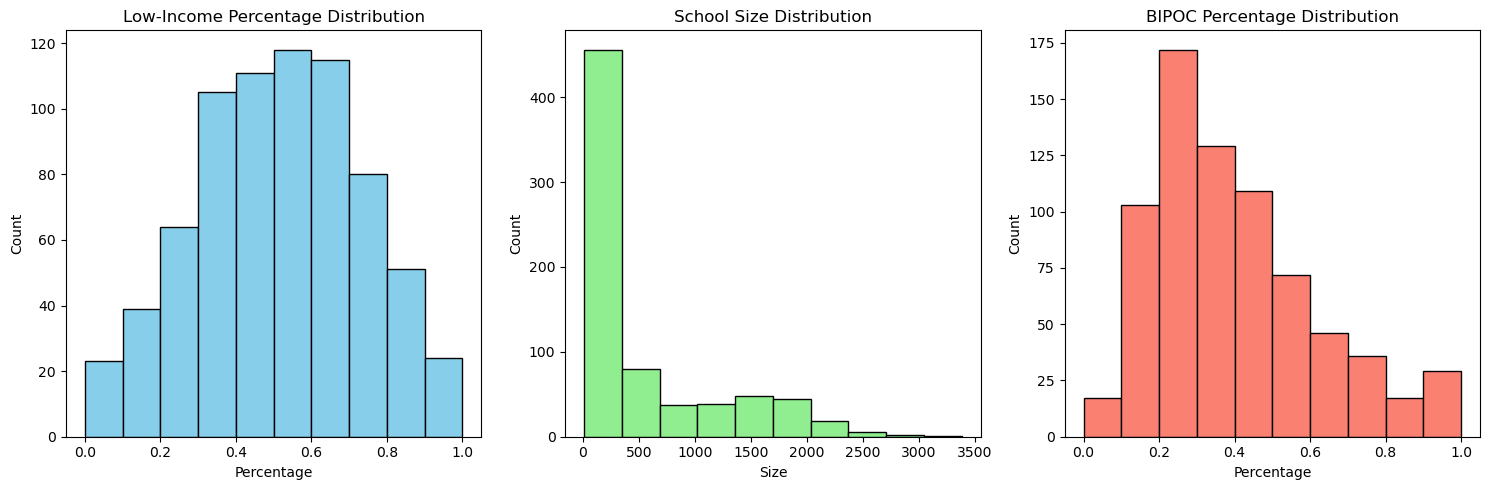

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

df = reduced_ospi

income_col = 'PercentLowIncome'
size_col = 'AllStudents'
bipoc_col = 'PercentBIPOC'

# Plot histograms for each feature
plt.figure(figsize=(15, 5))

# Low-income percentage histogram
plt.subplot(1, 3, 1)
plt.hist(df[income_col], bins=10, color='skyblue', edgecolor='black')
plt.title('Low-Income Percentage Distribution')
plt.xlabel('Percentage')
plt.ylabel('Count')

# School size histogram
plt.subplot(1, 3, 2)
plt.hist(df[size_col], bins=10, color='lightgreen', edgecolor='black')
plt.title('School Size Distribution')
plt.xlabel('Size')
plt.ylabel('Count')

# BIPOC percentage histogram
plt.subplot(1, 3, 3)
plt.hist(df[bipoc_col], bins=10, color='salmon', edgecolor='black')
plt.title('BIPOC Percentage Distribution')
plt.xlabel('Percentage')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [28]:
reduced_ospi['IncomeBinnedQtl'] = pd.qcut(ospi_data['PercentLowIncome'], 5, labels=['1', '2', '3', '4', '5'])
reduced_ospi['SchoolSizeBinnedQtl'] = pd.qcut(ospi_data['AllStudents'], 5, labels=['1', '2', '3', '4', '5'])
reduced_ospi['BIPOCBinnedQtl'] = pd.qcut(ospi_data['PercentBIPOC'], 5, labels=['1', '2', '3', '4', '5'])

## Preprocessing: Adding median household income by county feature
This data is pulled from https://ofm.wa.gov/washington-data-research/economy-and-labor-force/median-household-income-estimates

2023 is a projection, all others are estimates

In [29]:
median_income = pd.read_csv('median_income.csv')

In [30]:
median_income.head()

,Unnamed: 0,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Washington,"31,183","33,417","34,379","35,882","36,679","37,895","38,997","40,568","42,399","44,514","45,776","44,120","45,761","46,039","46,967","49,585","50,004","53,522","56,141","57,858","55,458","54,888","55,500","56,444","57,284","60,153","63,439","65,500","69,288","72,297","78,674","80,319","84,155","91,255","94,308"
1,Adams,"24,604","28,024","27,301","28,328","31,277","29,537","29,604","31,806","31,795","34,073","33,888","35,292","37,839","38,306","38,934","39,235","39,105","41,298","42,299","42,455","41,102","40,656","41,068","42,354","43,541","45,712","47,646","49,501","48,849","52,870","53,535","56,421","57,405","62,410","64,498"
2,Asotin,"22,897","24,206","25,110","26,251","27,359","27,873","28,288","29,813","31,499","32,477","33,524","32,590","35,920","37,013","37,080","37,140","37,657","39,768","40,558","42,945","40,035","39,820","40,171","41,703","42,174","43,368","46,107","47,020","51,767","50,746","54,776","53,377","56,438","65,625","67,820"
3,Benton,"32,593","35,012","37,093","39,228","41,153","42,790","42,540","42,817","44,057","45,665","47,044","49,389","52,598","53,736","55,409","57,613","56,200","54,942","55,361","57,114","58,496","60,070","60,608","62,739","63,710","63,157","62,071","62,282","63,502","67,912","72,847","75,882","77,339","85,144","87,992"
4,Chelan,"24,312","25,833","27,592","28,746","30,148","31,547","32,164","33,918","35,662","37,175","37,316","39,439","41,653","41,731","42,918","43,696","44,422","46,522","44,964","44,013","46,780","45,478","46,275","47,265","51,713","50,825","53,068","55,109","60,791","60,747","59,838","61,546","64,700","81,697","84,430"


In [31]:
median_income.columns

Index(['Unnamed: 0', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022',
       '2023'],
      dtype='object')

In [32]:
income = median_income[['Unnamed: 0','2022']]

In [33]:
income.columns = ['County','MedianIncome']

In [34]:
income.loc[:,'MedianIncome'] = income.loc[:,'MedianIncome'].str.strip()

In [35]:
income.loc[:,'MedianIncome'] = income.loc[:,'MedianIncome'].str.replace(',', '').astype(float)

In [36]:
income.dtypes

County          object
MedianIncome    object
dtype: object

In [37]:
with_income = pd.merge(reduced_ospi, income, on='County')

In [38]:
with_income.head()

,CountyPop,County,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,AllStudents,C_AllStudents,I_LowIncome,PercentLowIncome,R_BIPOC,PercentBIPOC,DistrictNumSchools,DistrictSize,DistrictLowIncome,DistrictPctLowIncome,DistrictBIPOC,DistrictPctBIPOC,CS_Offered,DistrictCS,DistrictPctCS,Western_WA,IncomeBinned,SchoolSizeBinned,BIPOCBinned,IncomeBinnedQtl,SchoolSizeBinnedQtl,BIPOCBinnedQtl,MedianIncome
0,20820,Adams,1109,3075,Washtucna Elementary/High School,-118.311231,46.752189,28,3,17,0.607143,4,0.142857,1,28,17,0.607143,4,0.142857,1,1,1.000000,0,4,1,1,4,1,1,62410.0
1,20820,Adams,1147,3015,Othello High School,-119.165246,46.822710,1281,169,1069,0.834504,1178,0.919594,3,1464,1235,0.843579,1346,0.919399,1,1,0.333333,0,5,4,5,5,5,5,62410.0
2,20820,Adams,1158,2903,Lind-Ritzville High School,-118.292516,47.125588,60,17,48,0.800000,28,0.466667,1,60,48,0.800000,28,0.466667,1,1,1.000000,0,4,1,3,5,2,4,62410.0
3,20820,Adams,1160,2132,Ritzville High School,-118.292516,47.125588,113,18,47,0.415929,14,0.123894,1,113,47,0.415929,14,0.123894,1,1,1.000000,0,3,2,1,2,2,1,62410.0
4,20820,Adams,1147,5367,Desert Oasis High School,-119.163036,46.818533,142,0,131,0.922535,130,0.915493,3,1464,1235,0.843579,1346,0.919399,0,1,0.333333,0,4,2,1,5,3,1,62410.0


## Preprocessing: Preparing for tree-based algorithms
*Because tree based algorithms are not sensitive to feature scaling.*

In [42]:
## First version, using all available features without further feature engineering
df_for_tree = reduced_ospi.loc[:, ('CountyPop','Western_WA','DistrictNumSchools','DistrictSize','CS_Offered','IncomeBinned','SchoolSizeBinned','BIPOCBinned')]

In [43]:
df_for_tree.head()

,CountyPop,Western_WA,DistrictNumSchools,DistrictSize,CS_Offered,IncomeBinned,SchoolSizeBinned,BIPOCBinned
0,20820,0,1,28,1,4,1,1
1,20820,0,3,1464,1,5,4,5
2,20820,0,1,60,1,4,1,3
3,20820,0,1,113,1,3,2,1
4,20820,0,3,1464,0,4,2,1


In [44]:
with_income.head()

,CountyPop,County,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,AllStudents,C_AllStudents,I_LowIncome,PercentLowIncome,R_BIPOC,PercentBIPOC,DistrictNumSchools,DistrictSize,DistrictLowIncome,DistrictPctLowIncome,DistrictBIPOC,DistrictPctBIPOC,CS_Offered,DistrictCS,DistrictPctCS,Western_WA,IncomeBinned,SchoolSizeBinned,BIPOCBinned,IncomeBinnedQtl,SchoolSizeBinnedQtl,BIPOCBinnedQtl,MedianIncome
0,20820,Adams,1109,3075,Washtucna Elementary/High School,-118.311231,46.752189,28,3,17,0.607143,4,0.142857,1,28,17,0.607143,4,0.142857,1,1,1.000000,0,4,1,1,4,1,1,62410.0
1,20820,Adams,1147,3015,Othello High School,-119.165246,46.822710,1281,169,1069,0.834504,1178,0.919594,3,1464,1235,0.843579,1346,0.919399,1,1,0.333333,0,5,4,5,5,5,5,62410.0
2,20820,Adams,1158,2903,Lind-Ritzville High School,-118.292516,47.125588,60,17,48,0.800000,28,0.466667,1,60,48,0.800000,28,0.466667,1,1,1.000000,0,4,1,3,5,2,4,62410.0
3,20820,Adams,1160,2132,Ritzville High School,-118.292516,47.125588,113,18,47,0.415929,14,0.123894,1,113,47,0.415929,14,0.123894,1,1,1.000000,0,3,2,1,2,2,1,62410.0
4,20820,Adams,1147,5367,Desert Oasis High School,-119.163036,46.818533,142,0,131,0.922535,130,0.915493,3,1464,1235,0.843579,1346,0.919399,0,1,0.333333,0,4,2,1,5,3,1,62410.0


In [45]:
## With median household income by county added
df_for_tree_v3 = with_income.loc[:, ('CountyPop','Western_WA','DistrictNumSchools','DistrictSize','CS_Offered','IncomeBinned','SchoolSizeBinned','BIPOCBinned','MedianIncome')]

In [46]:
df_for_tree_v3.head()

,CountyPop,Western_WA,DistrictNumSchools,DistrictSize,CS_Offered,IncomeBinned,SchoolSizeBinned,BIPOCBinned,MedianIncome
0,20820,0,1,28,1,4,1,1,62410.0
1,20820,0,3,1464,1,5,4,5,62410.0
2,20820,0,1,60,1,4,1,3,62410.0
3,20820,0,1,113,1,3,2,1,62410.0
4,20820,0,3,1464,0,4,2,1,62410.0


In [72]:
## With Quantile binning strategy 
df_for_tree_v4 = with_income.loc[:, ('CountyPop','Western_WA','DistrictNumSchools','DistrictSize','CS_Offered','IncomeBinnedQtl','SchoolSizeBinnedQtl','BIPOCBinnedQtl','MedianIncome')]

In [71]:
## With Quantile binning strategy, without Western_WA feature
df_for_tree_v5 = with_income.loc[:, ('CountyPop','DistrictNumSchools','DistrictSize','CS_Offered','IncomeBinnedQtl','SchoolSizeBinnedQtl','BIPOCBinnedQtl','MedianIncome')]

## Preprocessing: Standardizing
*Linear regression, logistic regression and principal component analysis will benefit from standardizing.*

In [47]:
from sklearn.preprocessing import StandardScaler

X_to_scale = with_income.loc[:, ('CountyPop','DistrictNumSchools','DistrictSize','IncomeBinned','SchoolSizeBinned','BIPOCBinned','MedianIncome')]
y = with_income['CS_Offered']

sc = StandardScaler()
X_scaled = sc.fit_transform(X_to_scale)

In [48]:
from sklearn.preprocessing import StandardScaler

X_to_scale2 = with_income.loc[:, ('CountyPop','DistrictNumSchools','DistrictSize','IncomeBinned','SchoolSizeBinned','BIPOCBinned','Western_WA','MedianIncome')]
y = with_income['CS_Offered']

sc = StandardScaler()
X_scaled2 = sc.fit_transform(X_to_scale2)

## Analysis: Random Forest

In [49]:
X_tree1 = df_for_tree.drop(['CS_Offered'], axis = 1)
y_tree1 = df_for_tree['CS_Offered']
X_train_tree1, X_test_tree1, y_train_tree1, y_test_tree1 = train_test_split(X_tree1, y_tree1, test_size=0.2)

In [50]:
param_dist_tree1 = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf_tree1 = RandomForestClassifier(random_state=25)

# Use random search to find the best hyperparameters
rand_search_tree1 = RandomizedSearchCV(rf_tree1, 
                                 param_distributions = param_dist_tree1, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search_tree1.fit(X_train_tree1, y_train_tree1)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=25),
                   n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1374b2510>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1375c2ed0>})

In [51]:
# Create a variable for the best model
best_rf_tree1 = rand_search_tree1.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search_tree1.best_params_)

Best hyperparameters: {'max_depth': 6, 'n_estimators': 368}


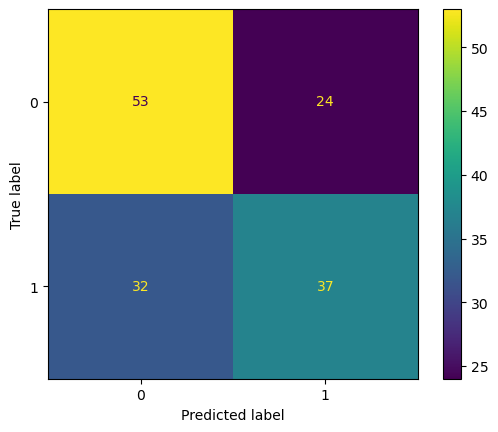

In [52]:
# Generate predictions with the best model
y_pred_tree1 = best_rf_tree1.predict(X_test_tree1)

# Create the confusion matrix
cm_tree1 = confusion_matrix(y_test_tree1, y_pred_tree1)

ConfusionMatrixDisplay(confusion_matrix=cm_tree1).plot();

In [53]:
accuracy_tree1 = accuracy_score(y_test_tree1, y_pred_tree1)
precision_tree1 = precision_score(y_test_tree1, y_pred_tree1)
recall_tree1 = recall_score(y_test_tree1, y_pred_tree1)

print("Accuracy:", accuracy_tree1)
print("Precision:", precision_tree1)
print("Recall:", recall_tree1)

Accuracy: 0.6164383561643836
Precision: 0.6065573770491803
Recall: 0.5362318840579711


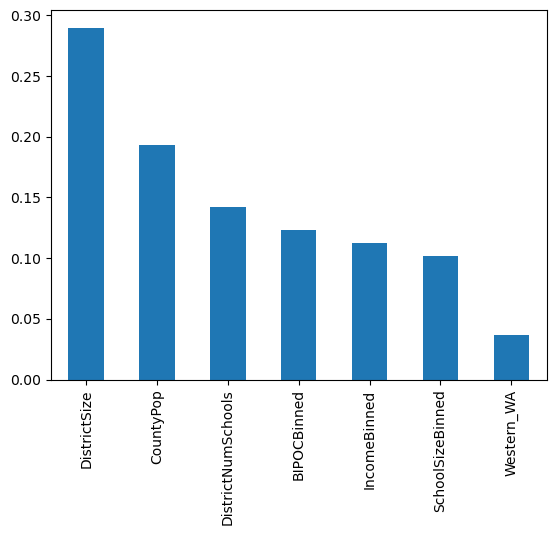

In [54]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances_tree1 = pd.Series(best_rf_tree1.feature_importances_, index=X_train_tree1.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances_tree1.plot.bar();

Best hyperparameters: {'max_depth': 13, 'n_estimators': 439}


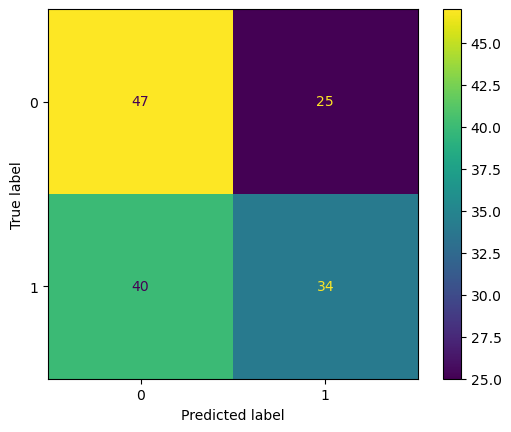

In [55]:
X_rf3 = df_for_tree_v3.drop(['CS_Offered'], axis = 1)
y_rf3 = df_for_tree_v3['CS_Offered']
X_train_rf3, X_test_rf3, y_train_rf3, y_test_rf3 = train_test_split(X_rf3, y_rf3, test_size=0.2)
param_dist_rf3 = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf_rf3 = RandomForestClassifier(random_state=25)

# Use random search to find the best hyperparameters
rand_search_rf3 = RandomizedSearchCV(rf_rf3, 
                                 param_distributions = param_dist_rf3, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search_rf3.fit(X_train_rf3, y_train_rf3)
# Create a variable for the best model
best_rf_rf3 = rand_search_rf3.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search_rf3.best_params_)
# Generate predictions with the best model
y_pred_rf3 = best_rf_rf3.predict(X_test_rf3)
# Generate predictions with the best model
y_pred_rf3 = best_rf_rf3.predict(X_test_rf3)

# Create the confusion matrix
cm_rf3 = confusion_matrix(y_test_rf3, y_pred_rf3)

ConfusionMatrixDisplay(confusion_matrix=cm_rf3).plot();

In [56]:
accuracy_rf3 = accuracy_score(y_test_rf3, y_pred_rf3)
precision_rf3 = precision_score(y_test_rf3, y_pred_rf3)
recall_rf3 = recall_score(y_test_rf3, y_pred_rf3)

print("Accuracy:", accuracy_rf3)
print("Precision:", precision_rf3)
print("Recall:", recall_rf3)

Accuracy: 0.5547945205479452
Precision: 0.576271186440678
Recall: 0.4594594594594595


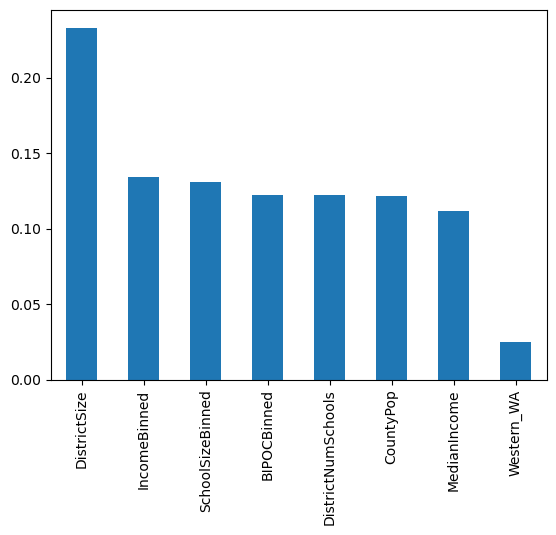

In [57]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances_tree3 = pd.Series(best_rf_rf3.feature_importances_, index=X_train_rf3.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances_tree3.plot.bar();

Best hyperparameters: {'max_depth': 5, 'n_estimators': 434}


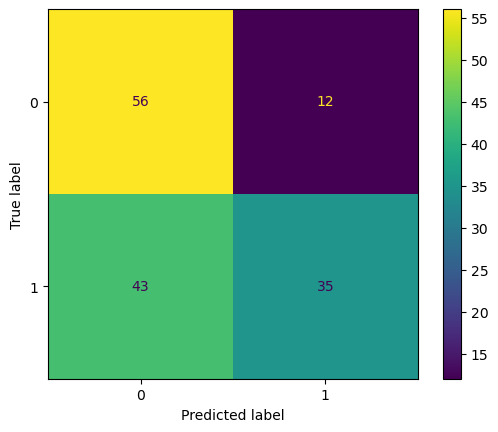

In [67]:
X_rf4 = df_for_tree_v4.drop(['CS_Offered'], axis = 1)
y_rf4 = df_for_tree_v4['CS_Offered']
X_train_rf4, X_test_rf4, y_train_rf4, y_test_rf4 = train_test_split(X_rf4, y_rf4, test_size=0.2)
param_dist_rf4 = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf_rf4 = RandomForestClassifier(random_state=25)

# Use random search to find the best hyperparameters
rand_search_rf4 = RandomizedSearchCV(rf_rf4, 
                                 param_distributions = param_dist_rf4, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search_rf4.fit(X_train_rf4, y_train_rf4)
# Create a variable for the best model
best_rf_rf4 = rand_search_rf4.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search_rf4.best_params_)
# Generate predictions with the best model
y_pred_rf4 = best_rf_rf4.predict(X_test_rf4)
# Generate predictions with the best model
y_pred_rf4 = best_rf_rf4.predict(X_test_rf4)

# Create the confusion matrix
cm_rf4 = confusion_matrix(y_test_rf4, y_pred_rf4)

ConfusionMatrixDisplay(confusion_matrix=cm_rf4).plot();

In [68]:
accuracy_rf4 = accuracy_score(y_test_rf4, y_pred_rf4)
precision_rf4 = precision_score(y_test_rf4, y_pred_rf4)
recall_rf4 = recall_score(y_test_rf4, y_pred_rf4)

print("Accuracy:", accuracy_rf4)
print("Precision:", precision_rf4)
print("Recall:", recall_rf4)

Accuracy: 0.6232876712328768
Precision: 0.7446808510638298
Recall: 0.44871794871794873


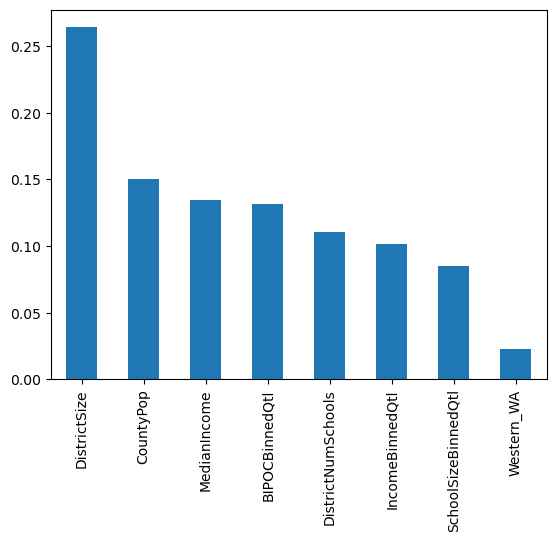

In [69]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances_tree4 = pd.Series(best_rf_rf4.feature_importances_, index=X_train_rf4.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances_tree4.plot.bar();

Best hyperparameters: {'max_depth': 4, 'n_estimators': 454}


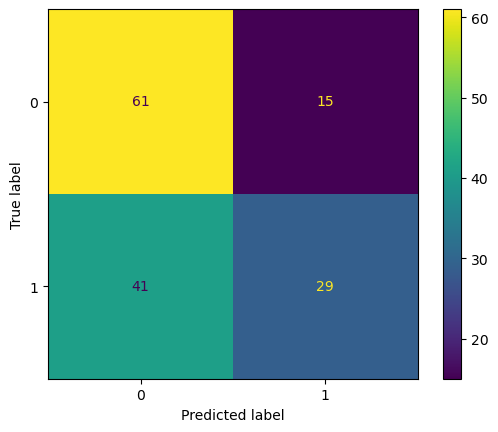

In [73]:
X_rf5 = df_for_tree_v5.drop(['CS_Offered'], axis = 1)
y_rf5 = df_for_tree_v5['CS_Offered']
X_train_rf5, X_test_rf5, y_train_rf5, y_test_rf5 = train_test_split(X_rf5, y_rf5, test_size=0.2)
param_dist_rf5 = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf_rf5 = RandomForestClassifier(random_state=25)

# Use random search to find the best hyperparameters
rand_search_rf5 = RandomizedSearchCV(rf_rf5, 
                                 param_distributions = param_dist_rf5, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search_rf5.fit(X_train_rf5, y_train_rf5)
# Create a variable for the best model
best_rf_rf5 = rand_search_rf5.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search_rf5.best_params_)
# Generate predictions with the best model
y_pred_rf5 = best_rf_rf5.predict(X_test_rf5)
# Generate predictions with the best model
y_pred_rf5 = best_rf_rf5.predict(X_test_rf5)

# Create the confusion matrix
cm_rf5 = confusion_matrix(y_test_rf5, y_pred_rf5)

ConfusionMatrixDisplay(confusion_matrix=cm_rf5).plot();

In [74]:
accuracy_rf5 = accuracy_score(y_test_rf5, y_pred_rf5)
precision_rf5 = precision_score(y_test_rf5, y_pred_rf5)
recall_rf5 = recall_score(y_test_rf5, y_pred_rf5)

print("Accuracy:", accuracy_rf5)
print("Precision:", precision_rf5)
print("Recall:", recall_rf5)

Accuracy: 0.6164383561643836
Precision: 0.6590909090909091
Recall: 0.4142857142857143


## Analysis: Logistic Regression
### Correlation Heatmap
*To ensure there is not multicollinearity with our independent variables*

In [58]:
df_logistic_reg = with_income.loc[:, ('CountyPop','Western_WA','DistrictSize','CS_Offered','IncomeBinned','SchoolSizeBinned','BIPOCBinned')]

In [59]:
df_logistic_reg.dtypes

CountyPop              int64
Western_WA            object
DistrictSize           int64
CS_Offered             int64
IncomeBinned        category
SchoolSizeBinned    category
BIPOCBinned         category
dtype: object

In [60]:
df_logistic_reg['IncomeBinned'] = df_logistic_reg['IncomeBinned'].cat.codes
df_logistic_reg['SchoolSizeBinned'] = df_logistic_reg['SchoolSizeBinned'].cat.codes
df_logistic_reg['BIPOCBinned'] = df_logistic_reg['BIPOCBinned'].cat.codes

In [61]:
df_logistic_reg.dtypes

CountyPop            int64
Western_WA          object
DistrictSize         int64
CS_Offered           int64
IncomeBinned          int8
SchoolSizeBinned      int8
BIPOCBinned           int8
dtype: object

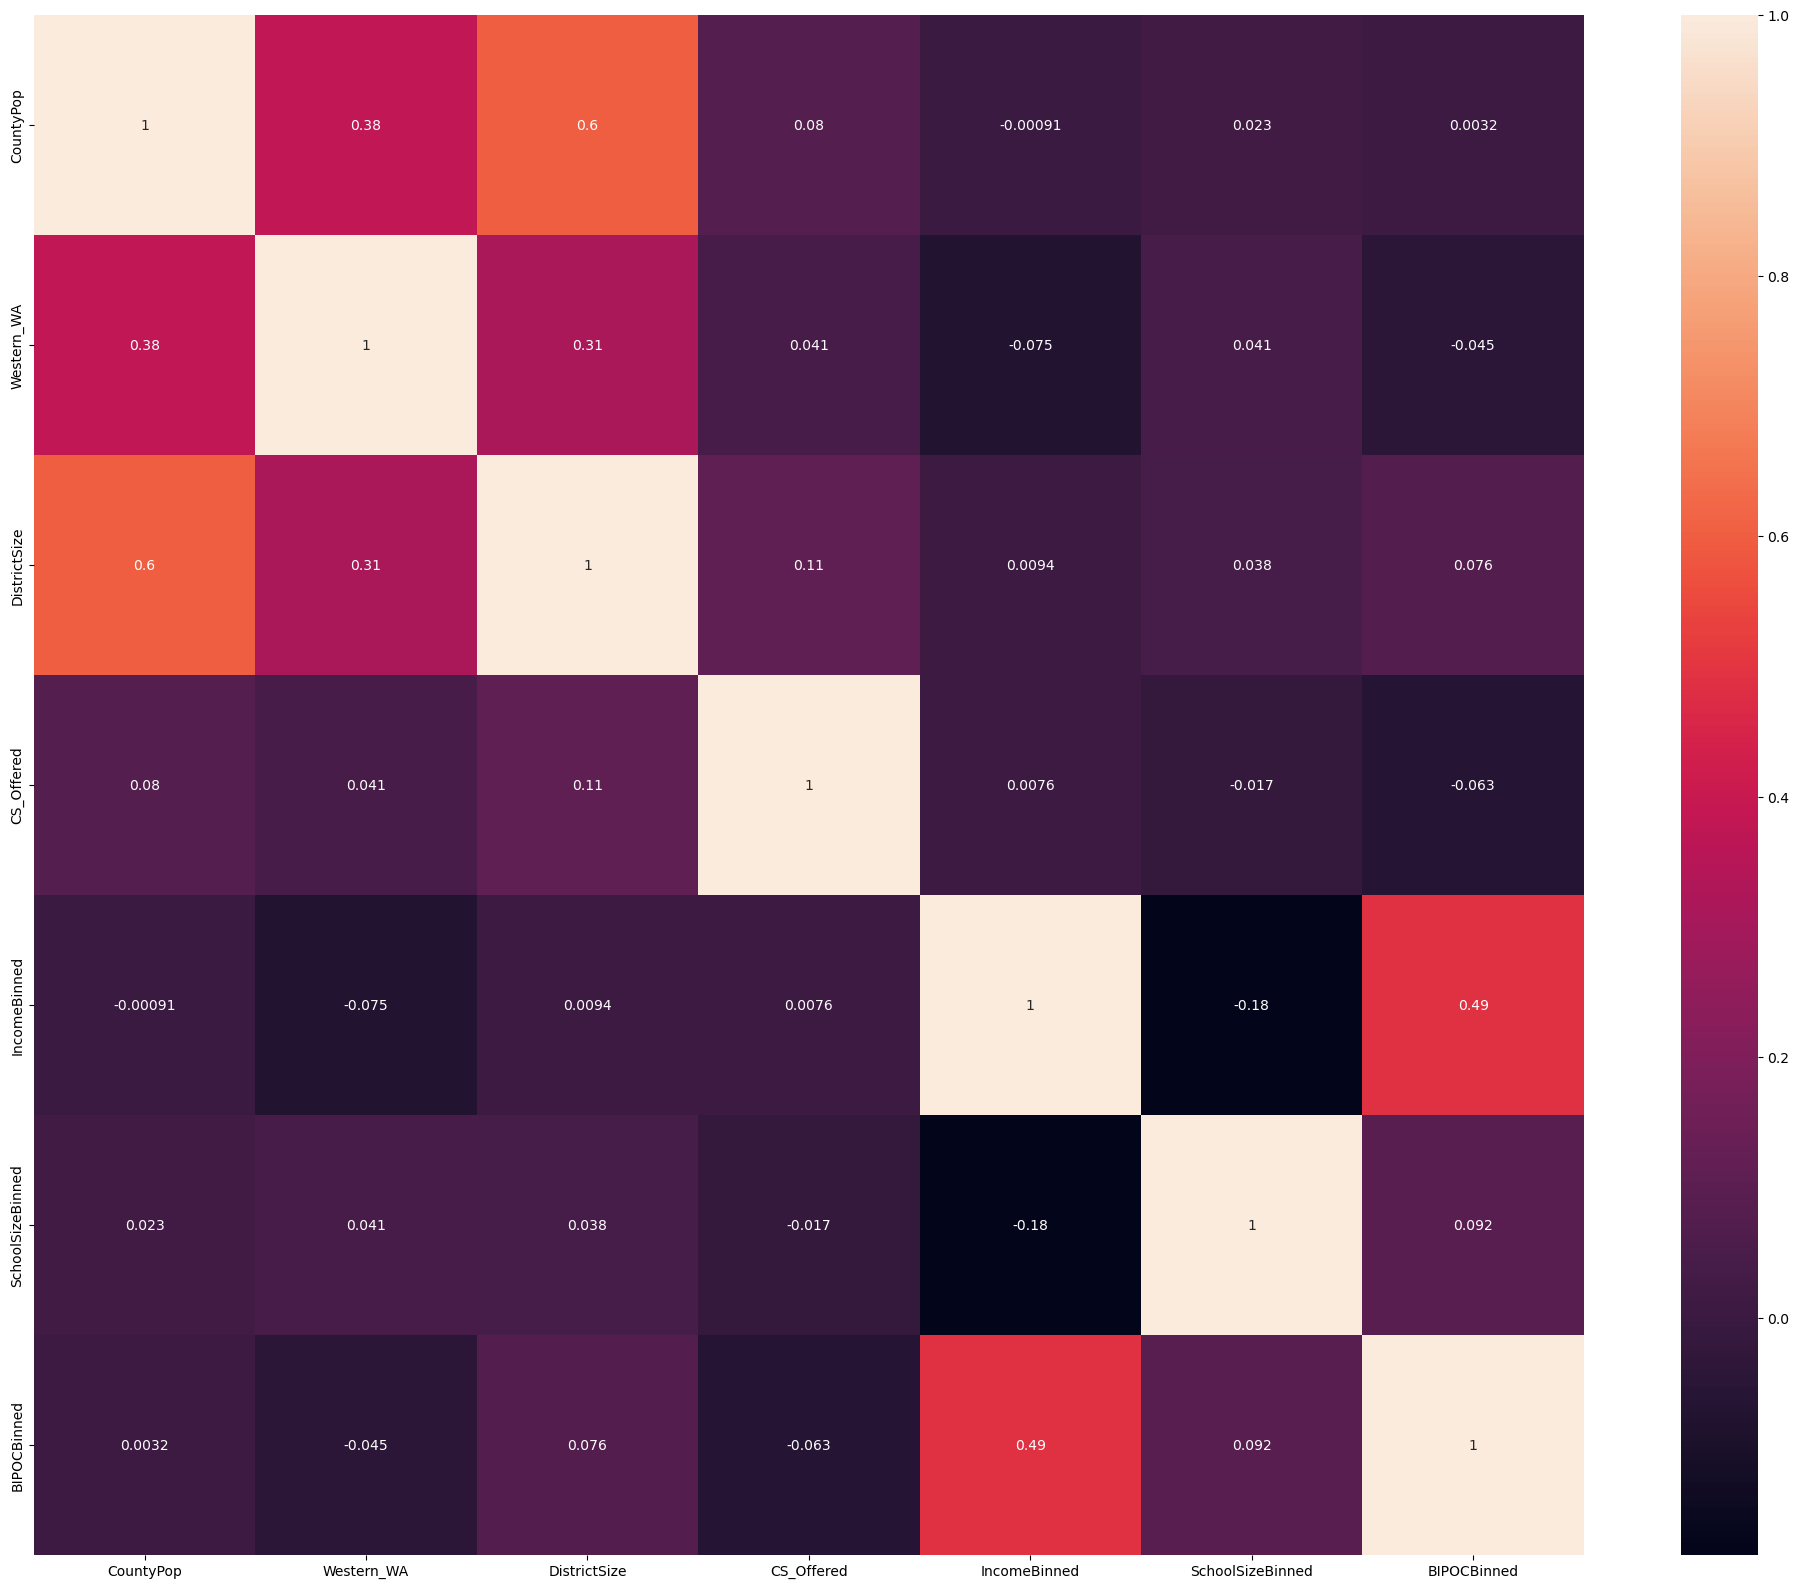

In [62]:
fig = plt.figure(figsize=(25, 20))
sns.heatmap(df_logistic_reg.corr(), annot=True)
plt.savefig("Heatmap.png")

None of these features have high correlation (over .7) with one another, so we can continue this analysis. Keeping in mind that the sample size may not be large enough to yield significant results. Four features with the highest correlation to be mindful of:

* DistrictSize and CountyPop: .6
* IncomeBinned and BIPOCBinned: .49

To further investigate and protect against multicollinearity we can also use VIF.

In [63]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X_lr1.columns
vif_data["VIF"] = [variance_inflation_factor(X_lr1.values, i) for i in range(X_lr1.shape[1])]
print(vif_data)

NameError: name 'X_lr1' is not defined

In [ ]:
scaler = StandardScaler()
X_scaled_lr1 = scaler.fit_transform(X_lr1)

In [ ]:
X_lr1 = df_logistic_reg.drop(['CS_Offered'], axis = 1)
y_lr1 = df_logistic_reg['CS_Offered']

X_train_lr1, X_test_lr1, y_train_lr1, y_test_lr1 = train_test_split(X_lr1, y_lr1, test_size=0.3, random_state=0)
logreg_lr1 = LogisticRegression()
logreg_lr1.fit(X_train_lr1, y_train_lr1)

In [ ]:
y_pred_lr1 = logreg_lr1.predict(X_test_lr1)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg_lr1.score(X_test_lr1, y_test_lr1)))

In [ ]:
cm_lr1 = confusion_matrix(y_test_lr1, y_pred_lr1)

ConfusionMatrixDisplay(confusion_matrix=cm_lr1).plot();

The inaccuracy here may be due to the insufficient amount of data.

## Analysis: PCA  

In [ ]:
# Apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=7)
pca.fit(X_scaled)

# Get the eigenvalues
print("Eigenvalues:")
print(pca.explained_variance_)
print()

# Get explained variances
print("Variances (Percentage):")
print(pca.explained_variance_ratio_ * 100)
print()

# Make the scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components (Dimensions)")
plt.ylabel("Explained variance (%)")

In [ ]:
X_to_scale.columns

In [ ]:
feature_names = X_to_scale.columns
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'], index=feature_names)
loading_matrix

In [ ]:
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative variance explained:", pca.explained_variance_ratio_.cumsum())

### Principal Components: Key Contributing Features
* **PC1 (43%)**:  CountyPop, DistrictNumSchools, DistrictSize, MedianIncome

* **PC2 (21%)**:  IncomeBinned, BIPOCBinned

* **PC3 (15%)**:  SchoolSizeBinned

* **PC4 (12%)**:  CountyPop, DistrictNumSchools, MedianIncome (*.4 < loadings < .5*, but strongest of this PC)

* **PC5 (6%)**:  IncomeBinned, BIPOCBinned (*.4 < loadings < .5*, but strongest of this PC)

* **PC6-PC7 (<3%)**: No strong contributing features

In [ ]:
# Apply PCA
from sklearn.decomposition import PCA
pca2 = PCA(n_components=8)
pca2.fit(X_scaled2)

# Get the eigenvalues
print("Eigenvalues:")
print(pca2.explained_variance_)
print()

# Get explained variances
print("Variances (Percentage):")
print(pca2.explained_variance_ratio_ * 100)
print()

# Make the scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components (Dimensions)")
plt.ylabel("Explained variance (%)")

In [ ]:
X_to_scale2.columns

In [ ]:
pca2.components_

In [ ]:
feature_names2 = X_to_scale2.columns
loadings2 = pca2.components_.T * np.sqrt(pca2.explained_variance_)
loading_matrix2 = pd.DataFrame(loadings2, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8'], index=feature_names2)
loading_matrix2

In [ ]:
feature_names = X_to_scale.columns
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'], index=feature_names)
loading_matrix

In [ ]:
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative variance explained:", pca.explained_variance_ratio_.cumsum())

## Mutual Information

In [ ]:
X_mi = X_to_scale2
y_mi = with_income['CS_Offered']
X_train_mi, X_test_mi, y_train_mi, y_test_mi = train_test_split(X_mi, y_mi, test_size=0.2, random_state=1234)

In [ ]:
from sklearn.feature_selection import mutual_info_classif
mutual_info = mutual_info_classif(X_train_mi, y_train_mi)
mutual_info

mutual_info = mutual_info_classif(X_train_mi, y_train_mi)
mutual_info

In [ ]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train_mi.columns
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

## Analysis: Ensemble Learning
TODO: Re-run after feature encoding above  
This is a very basic first run at ensemble learning...will improve

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.ensemble import RandomForestClassifier 
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
# import statistics as st
# import warnings
# warnings.filterwarnings('ignore')

# # SPLITTING THE DATASET
# df = reduced_ospi
# x = df.drop(['CS_Offered', 'SchoolName', 'County'], axis = 1)
# y = df['CS_Offered']
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# # MODELS CREATION
# model1 = RandomForestClassifier()
# model2 = KNeighborsClassifier()
# model3= LogisticRegression()

# model1.fit(x_train,y_train)
# model2.fit(x_train,y_train)
# model3.fit(x_train,y_train)

# # PREDICTION
# pred1=model1.predict(x_test)
# pred2=model2.predict(x_test)
# pred3=model3.predict(x_test)

# # FINAL_PREDICTION
# final_pred = np.array([])
# for i in range(0,len(x_test)):
#     final_pred = np.append(final_pred, st.mode([pred1[i], pred2[i], pred3[i]]))
# print(final_pred)